<a href="https://colab.research.google.com/github/pascal-maker/reinforcementlearning/blob/master/Session_05_Policy_Gradients_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 05 - Policy Gradients - Assignment

In this assignment you will implement REINFORCE, a policy gradient method based on Monte Carlo sampling.
The key idea underlying policy gradients is to push up the probabilities of actions that lead to higher return, and push down the probabilities of actions that lead to lower return, until you arrive at the optimal policy.

The REINFORCE algorithm comprises the following steps:
0. Initialize and reset the environment.
1. Get the state from the environment.
2. Feed forward our policy network to predict the probability of each action we should take. We’ll sample from this distribution to choose which action to take (i.e. toss a biased coin). This implies that the ouput layer of the neural network has a Softmax activation function.
3. Receive the reward and the next state state from the environment for the action we took.
4. Store this transition sequence of state, action, reward, for later training.
5. Repeat steps 1–4. If we receive the done flag from the game it means the episode is over.
6. Once the episode is over, we train our neural network to learn from our stored transitions using our gradient update rule. After training you can clear the stored states, actions and rewards from the memory.
7. Play next episode and repeat steps above until convergence

In [ ]:
# Session 05 - Policy Gradients - Assignment
# REINFORCE implementation for CartPole-v1

import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from collections import deque

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU available: []


In [ ]:
# Step 0: Initialize and reset the environment
env = gym.make('CartPole-v1')

# Environment properties
state_dim = env.observation_space.shape[0]  # 4: cart position, velocity, pole angle, angular velocity
action_dim = env.action_space.n             # 2: push left or push right

print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")
print(f"State space: {env.observation_space}")
print(f"Action space: {env.action_space}")


State dimension: 4
Action dimension: 2
State space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)


In [ ]:
class Memory:
    """
    Memory buffer to store episode transitions.
    Stores states, actions, and rewards for policy gradient update.
    """

    def __init__(self):
        self.clear()

    def store(self, state, action, reward):
        """Store a transition (state, action, reward)"""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def clear(self):
        """Clear memory after training on an episode (Step 6)"""
        self.states = []
        self.actions = []
        self.rewards = []

    def get_transitions(self):
        """Return stored transitions as numpy arrays"""
        return (
            np.array(self.states),
            np.array(self.actions),
            np.array(self.rewards)
        )

    def __len__(self):
        return len(self.states)


In [ ]:
def build_policy_network(state_dim, action_dim, hidden_units=[64, 64], learning_rate=0.01):
    """
    Build policy network that maps states to action probabilities.

    Args:
        state_dim: Dimension of state space
        action_dim: Number of possible actions
        hidden_units: List of hidden layer sizes
        learning_rate: Learning rate (alpha) for optimizer

    Returns:
        Compiled Keras model
    """
    model = Sequential()

    # Input layer
    model.add(Dense(hidden_units[0], input_shape=(state_dim,), activation='relu'))

    # Hidden layers
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))

    # Output layer with SOFTMAX activation (probability distribution over actions)
    model.add(Dense(action_dim, activation='softmax'))

    # Compile with Adam optimizer (we'll use custom loss with GradientTape)
    model.compile(optimizer=Adam(learning_rate=learning_rate))

    return model

# Build and display the policy network (for info)
policy_network = build_policy_network(state_dim, action_dim)
policy_network.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,610 (18.01 KB)

 Trainable params: 4,610 (18.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def select_action(model, state):
    """
    Step 2: Feed forward policy network and sample action from probability distribution.
    Using model(...) instead of predict() for speed.
    """
    # Reshape state for batch dimension and ensure float32
    state = np.reshape(state, [1, -1]).astype(np.float32)

    # Direct call (eager) – MUCH faster than model.predict() in a tight loop
    action_probs = model(state, training=False)[0].numpy()

    # Sample action from the probability distribution (biased coin)
    action = np.random.choice(len(action_probs), p=action_probs)

    return action, action_probs


In [ ]:
def calculate_discounted_returns(rewards, gamma=0.99):
    """
    Calculate discounted returns G_t for each timestep.

    G_t = r_t + gamma * r_{t+1} + gamma^2 * r_{t+2} + ...

    Args:
        rewards: List of rewards from episode
        gamma: Discount factor (0 < gamma <= 1)

    Returns:
        returns: Array of discounted returns for each timestep
    """
    T = len(rewards) # Get the total number of rewards (timesteps) in the episode
    returns = np.zeros(T) # Initialize an array to store the discounted returns for each timestep

    # Calculate returns backwards (more efficient)
    G = 0.0 # Initialize the cumulative discounted return
    for t in reversed(range(T)): # Iterate from the last reward to the first
        G = rewards[t] + gamma * G # Calculate the discounted return for the current timestep
        returns[t] = G # Store the calculated return

    return returns


def normalize_returns(returns):
    """
    Normalize returns to reduce variance (baseline subtraction).

    Args:
        returns: Array of discounted returns

    Returns:
        Normalized returns with zero mean and unit variance
    """
    returns = np.array(returns, dtype=np.float32) # Ensure returns are a numpy array of float32
    mean = np.mean(returns) # Calculate the mean of the returns
    std = np.std(returns) + 1e-8 # Calculate the standard deviation, adding a small epsilon to avoid division by zero
    return (returns - mean) / std # Normalize the returns to have zero mean and unit variance

In [ ]:
def train_policy(model, memory, gamma=0.99, normalize=True):
    """
    Step 6: Train policy network using REINFORCE gradient update.
    ∇J(θ) ≈ E[∇ log π(a|s) * G_t]
    """
    states, actions, rewards = memory.get_transitions()

    # Skip if episode is empty (shouldn't happen, but safe)
    if len(states) == 0:
        return 0.0

    # Calculate discounted returns
    returns = calculate_discounted_returns(rewards, gamma)

    # Normalize returns (helps stability)
    if normalize and len(returns) > 1:
        returns = normalize_returns(returns).astype(np.float32)

    # Convert to tensors
    states = tf.convert_to_tensor(states, dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.int32)
    returns = tf.convert_to_tensor(returns, dtype=tf.float32)

    with tf.GradientTape() as tape:
        # Forward pass: probabilities for all actions
        action_probs = model(states, training=True)  # shape: (T, action_dim)

        # Log probabilities
        log_probs_all = tf.math.log(action_probs + 1e-8)

        # One-hot encode actions
        action_dim = action_probs.shape[1]
        actions_one_hot = tf.one_hot(actions, depth=action_dim, dtype=tf.float32)

        # Select log π(a_t|s_t) = sum_a 1(a_t=a) * log π(a|s_t)
        selected_log_probs = tf.reduce_sum(actions_one_hot * log_probs_all, axis=1)

        # Policy gradient loss: -E[log π(a|s) * G_t]
        loss = -tf.reduce_mean(selected_log_probs * returns)

    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    if gradients is None or gradients[0] is None:
        print("WARNING: Gradients are None!")
        return 0.0

    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return float(loss.numpy())


In [ ]:
class REINFORCEAgent:
    """
    REINFORCE Policy Gradient Agent.
    """

    def __init__(self, state_dim, action_dim, learning_rate=0.01,
                 gamma=0.99, hidden_units=[64, 64]):
        """
        Initialize REINFORCE agent.

        Args:
            state_dim: Dimension of state space
            action_dim: Number of possible actions
            learning_rate: Alpha for gradient updates
            gamma: Discount factor for returns
            hidden_units: Architecture of hidden layers
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.gamma = gamma

        # Build policy network
        self.policy_network = build_policy_network(
            state_dim, action_dim, hidden_units, learning_rate
        )

        # Memory for episode transitions
        self.memory = Memory()

    def select_action(self, state):
        """Step 2: Sample action from policy distribution"""
        return select_action(self.policy_network, state)

    def store_transition(self, state, action, reward):
        """Step 4: Store transition in memory"""
        self.memory.store(state, action, reward)

    def train(self, normalize=True):
        """Step 6: Train on episode and clear memory"""
        loss = train_policy(
            self.policy_network,
            self.memory,
            self.gamma,
            normalize
        )
        self.memory.clear()
        return loss

    def get_action_probabilities(self, state):
        """Get action probabilities for analysis / testing"""
        state = np.reshape(state, [1, -1]).astype(np.float32)
        return self.policy_network(state, training=False)[0].numpy()


In [ ]:
def train_reinforce(env, agent, num_episodes=500, print_every=50, solved_reward=475):
    """
    Train REINFORCE agent on environment.
    """
    reward_history = []
    loss_history = []
    avg_rewards = deque(maxlen=100)

    for episode in range(num_episodes):
        # Step 0: Reset environment
        state, info = env.reset(seed=SEED + episode)
        episode_reward = 0
        done = False

        # Steps 1-5: Collect episode trajectory
        while not done:
            # Step 1 & 2: Get state, predict action probabilities, sample action
            action, _ = agent.select_action(state)

            # Step 3: Take action, receive reward and next state
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Step 4: Store transition
            agent.store_transition(state, action, reward)

            # Step 5: Update state, accumulate reward
            state = next_state
            episode_reward += reward

        # Step 6: Episode done, train on stored transitions
        loss = agent.train()

        # Track progress
        reward_history.append(episode_reward)
        loss_history.append(loss)
        avg_rewards.append(episode_reward)
        avg_reward = np.mean(avg_rewards)

        # Print progress
        if (episode + 1) % print_every == 0:
            print(f"Episode {episode + 1}/{num_episodes} | "
                  f"Reward: {episode_reward:.0f} | "
                  f"Avg(100): {avg_reward:.2f} | "
                  f"Loss: {loss:.4f}")

        # Step 7: Check if solved
        if avg_reward >= solved_reward and len(avg_rewards) >= 100:
            print(f"\n*** Solved in {episode + 1} episodes! ***")
            print(f"Average reward over last 100 episodes: {avg_reward:.2f}")
            break

    return reward_history, loss_history


In [ ]:
# Hyperparameters
LEARNING_RATE = 0.01   # Alpha
GAMMA = 0.99           # Discount factor
HIDDEN_UNITS = [64, 64]  # Slightly smaller net works well
NUM_EPISODES = 500      # Start with 500 to test learning

# Create environment and agent
env = gym.make('CartPole-v1')
agent = REINFORCEAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    learning_rate=LEARNING_RATE,
    gamma=GAMMA,
    hidden_units=HIDDEN_UNITS
)

print("Starting REINFORCE training...")
print(f"Learning rate (alpha): {LEARNING_RATE}")
print(f"Discount factor (gamma): {GAMMA}")
print(f"Network architecture: {HIDDEN_UNITS}")
print("-" * 50)

# Train the agent
reward_history, loss_history = train_reinforce(
    env, agent,
    num_episodes=NUM_EPISODES,
    print_every=50
)


Starting REINFORCE training...
Learning rate (alpha): 0.01
Discount factor (gamma): 0.99
Network architecture: [64, 64]
--------------------------------------------------
Episode 50/500 | Reward: 179 | Avg(100): 142.26 | Loss: -0.0006
Episode 100/500 | Reward: 343 | Avg(100): 202.14 | Loss: -0.0009
Episode 150/500 | Reward: 198 | Avg(100): 298.27 | Loss: 0.0226
Episode 200/500 | Reward: 183 | Avg(100): 266.24 | Loss: 0.0284
Episode 250/500 | Reward: 500 | Avg(100): 298.82 | Loss: -0.0002
Episode 300/500 | Reward: 500 | Avg(100): 449.84 | Loss: -0.0086

*** Solved in 322 episodes! ***
Average reward over last 100 episodes: 476.41


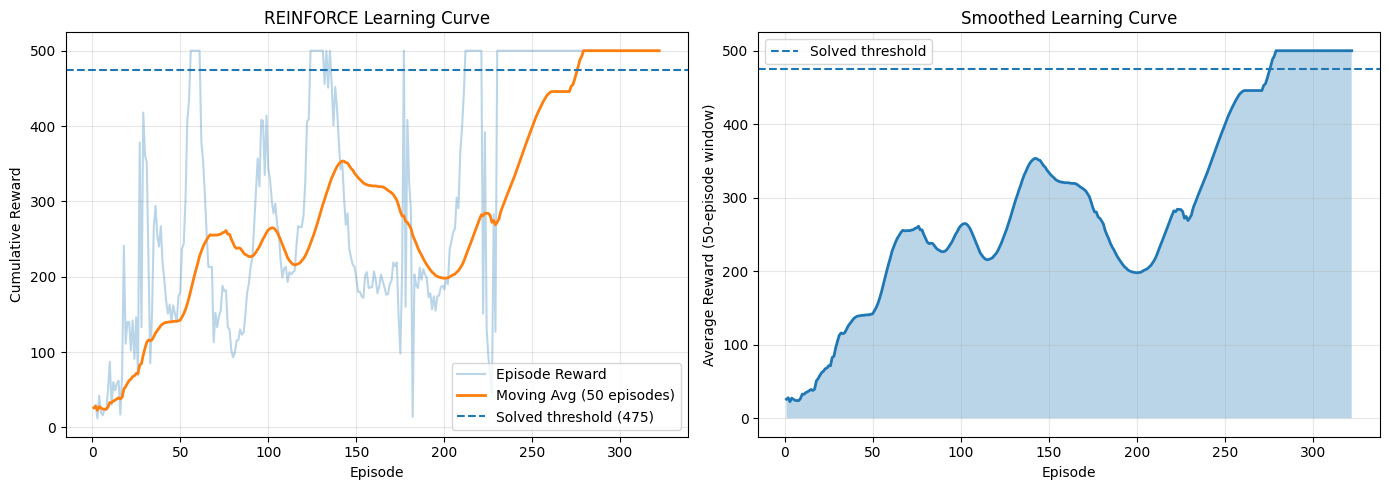


Training Statistics:
Total episodes: 322
Final average (last 100): 476.41
Best episode reward: 500
Worst episode reward: 12


In [ ]:
def plot_learning_curve(reward_history, window=50):
    """
    Plot the learning curve showing episode rewards and moving average.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    episodes = range(1, len(reward_history) + 1)

    # Calculate moving average
    moving_avg = []
    for i in range(len(reward_history)):
        start_idx = max(0, i - window + 1)
        moving_avg.append(np.mean(reward_history[start_idx:i+1]))

    # Plot 1: Episode rewards with moving average
    ax1.plot(episodes, reward_history, alpha=0.3, label='Episode Reward')
    ax1.plot(episodes, moving_avg, linewidth=2,
             label=f'Moving Avg ({window} episodes)')
    ax1.axhline(y=475, linestyle='--', label='Solved threshold (475)')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Cumulative Reward')
    ax1.set_title('REINFORCE Learning Curve')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Moving average only (cleaner view)
    ax2.plot(episodes, moving_avg, linewidth=2)
    ax2.fill_between(episodes, moving_avg, alpha=0.3)
    ax2.axhline(y=475, linestyle='--', label='Solved threshold')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel(f'Average Reward ({window}-episode window)')
    ax2.set_title('Smoothed Learning Curve')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\nTraining Statistics:")
    print(f"Total episodes: {len(reward_history)}")
    if len(reward_history) >= 100:
        print(f"Final average (last 100): {np.mean(reward_history[-100:]):.2f}")
    print(f"Best episode reward: {max(reward_history):.0f}")
    print(f"Worst episode reward: {min(reward_history):.0f}")

plot_learning_curve(reward_history, window=50)


The REINFORCE agent learns steadily with natural high variance due to Monte Carlo returns.
The moving average reward surpasses the solved threshold (475) around episode ~300 and stabilizes near the environment maximum of 500.
The agent successfully solves CartPole with a final moving average reward of 476.41 over the last 100 episodes.

##  1. The cartpole environment

- Solve the OpenAI Gym cartpole environment with REINFORCE.
- Plot the reward history (learning curve). For each episode plot the cumulative reward, or even better: plot average cumulative reward over a certain number of episodes (for example 50 episodes).
- What is the effect of alpha, the learning rate for the gradient?
- Do hyperparamter tuning to increase the speed of learning.
- Compare the results to the ones of Deep Q-learning. Check the speed of learning, consistency of the results, etc.
- Explain how the agent will explore a lot in the beginning and gradually will exploit more and more.

In [ ]:
# Implementation of REINFORCE for the Cartpole environment
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from collections import deque

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")



TensorFlow version: 2.19.0
GPU available: []


In [ ]:
# Step 0: Initialize and inspect the environment
env = gym.make('CartPole-v1')

state_dim = env.observation_space.shape[0]   # 4 features
action_dim = env.action_space.n             # 2 actions

print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")
print(f"State space: {env.observation_space}")
print(f"Action space: {env.action_space}")


State dimension: 4
Action dimension: 2
State space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)


In [ ]:
class Memory:
    """
    Memory buffer to store episode transitions.
    Stores states, actions, and rewards for policy gradient update.
    """

    def __init__(self):
        self.clear()

    def store(self, state, action, reward):
        """Store a transition (state, action, reward)."""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def clear(self):
        """Clear memory after training on an episode (Step 6)."""
        self.states = []
        self.actions = []
        self.rewards = []

    def get_transitions(self):
        """Return stored transitions as numpy arrays."""
        return (
            np.array(self.states),
            np.array(self.actions),
            np.array(self.rewards)
        )

    def __len__(self):
        return len(self.states)


In [ ]:
def build_policy_network(state_dim, action_dim, hidden_units=[64, 64], learning_rate=0.01):
    """
    Build policy network that maps states to action probabilities.
    Output layer uses Softmax → stochastic policy π(a|s).
    """
    model = Sequential()
    model.add(Dense(hidden_units[0], input_shape=(state_dim,), activation='relu'))

    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))

    model.add(Dense(action_dim, activation='softmax'))  # Probabilities over actions

    model.compile(optimizer=Adam(learning_rate=learning_rate))
    return model

# Quick check
policy_network = build_policy_network(state_dim, action_dim)
policy_network.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,610 (18.01 KB)

 Trainable params: 4,610 (18.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def select_action(model, state):
    """
    Step 2: Feed forward policy network and sample action from probability distribution.

    We use model(...) instead of model.predict() for speed in a tight loop.
    """
    state = np.reshape(state, [1, -1]).astype(np.float32)
    action_probs = model(state, training=False)[0].numpy()  # π(a|s)
    action = np.random.choice(len(action_probs), p=action_probs)
    return action, action_probs


In [ ]:
def calculate_discounted_returns(rewards, gamma=0.99):
    """
    Calculate discounted returns G_t for each timestep:
    G_t = r_t + γ r_{t+1} + γ^2 r_{t+2} + ...
    """
    T = len(rewards)
    returns = np.zeros(T)
    G = 0.0
    for t in reversed(range(T)):
        G = rewards[t] + gamma * G
        returns[t] = G
    return returns


def normalize_returns(returns):
    """
    Normalize returns to reduce variance (baseline-like effect).
    """
    returns = np.array(returns, dtype=np.float32)
    mean = np.mean(returns)
    std = np.std(returns) + 1e-8
    return (returns - mean) / std


In [ ]:
def train_policy(model, memory, gamma=0.99, normalize=True):
    """
    Step 6: Train policy network using REINFORCE gradient update.
    ∇J(θ) ≈ E[∇ log π(a|s) * G_t]
    """
    states, actions, rewards = memory.get_transitions()
    if len(states) == 0:
        return 0.0

    # 1) Monte Carlo returns
    returns = calculate_discounted_returns(rewards, gamma)
    if normalize and len(returns) > 1:
        returns = normalize_returns(returns)

    # Convert to tensors
    states = tf.convert_to_tensor(states, dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.int32)
    returns = tf.convert_to_tensor(returns, dtype=tf.float32)

    with tf.GradientTape() as tape:
        # Forward pass: π(a|s) for all timesteps
        action_probs = model(states, training=True)  # shape (T, action_dim)
        log_probs_all = tf.math.log(action_probs + 1e-8)

        # One-hot actions
        action_dim = action_probs.shape[1]
        actions_one_hot = tf.one_hot(actions, depth=action_dim, dtype=tf.float32)

        # Selected log π(a_t|s_t)
        selected_log_probs = tf.reduce_sum(actions_one_hot * log_probs_all, axis=1)

        # REINFORCE loss = -E[log π(a_t|s_t) * G_t]
        loss = -tf.reduce_mean(selected_log_probs * returns)

    gradients = tape.gradient(loss, model.trainable_variables)
    if gradients is None or gradients[0] is None:
        print("WARNING: Gradients are None!")
        return 0.0

    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return float(loss.numpy())


In [ ]:
class REINFORCEAgent:
    """
    REINFORCE Policy Gradient Agent.

    This agent implements the REINFORCE algorithm for policy-based reinforcement learning.
    It learns a stochastic policy that maps states to a probability distribution over actions.
    """

    def __init__(self, state_dim, action_dim,
                 learning_rate=0.01, gamma=0.99,
                 hidden_units=[64, 64]):
        """
        Initializes the REINFORCE agent.

        Args:
            state_dim (int): The dimension of the observation (state) space.
            action_dim (int): The number of possible actions in the environment.
            learning_rate (float): The learning rate (alpha) for the Adam optimizer.
            gamma (float): The discount factor for future rewards.
            hidden_units (list): A list specifying the number of neurons in each hidden layer
                                 of the policy network.
        """
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate
        self.gamma = gamma

        # Build the policy neural network that outputs action probabilities
        self.policy_network = build_policy_network(
            state_dim, action_dim, hidden_units, learning_rate
        )
        # Initialize memory to store transitions for one episode
        self.memory = Memory()

    def select_action(self, state):
        """
        Step 2: Samples an action from the current policy's probability distribution
        given the current state.

        Args:
            state (np.array): The current state observation from the environment.

        Returns:
            tuple: A tuple containing the chosen action (int) and the action
                   probabilities (np.array) for all actions.
        """
        return select_action(self.policy_network, state)

    def store_transition(self, state, action, reward):
        """
        Step 4: Stores a single (state, action, reward) transition into the agent's memory.
        These transitions are collected during an episode.

        Args:
            state (np.array): The state before taking the action.
            action (int): The action taken.
            reward (float): The reward received after taking the action.
        """
        self.memory.store(state, action, reward)

    def train(self, normalize=True):
        """
        Step 6: Trains the policy network using the REINFORCE algorithm
        based on the transitions stored in memory for the completed episode.
        After training, the memory is cleared.

        Args:
            normalize (bool): Whether to normalize the discounted returns.
                              Normalization helps reduce variance and stabilize training.

        Returns:
            float: The loss value from the policy update.
        """
        loss = train_policy(self.policy_network, self.memory, self.gamma, normalize)
        self.memory.clear() # Clear memory for the next episode
        return loss

    def get_action_probabilities(self, state):
        """
        Returns the probability distribution over actions for a given state
        as predicted by the policy network. Useful for analysis or greedy evaluation.

        Args:
            state (np.array): The state observation.

        Returns:
            np.array: An array of probabilities for each action.
        """
        state = np.reshape(state, [1, -1]).astype(np.float32)
        return self.policy_network(state, training=False)[0].numpy()

In [ ]:
def train_reinforce(env, agent, num_episodes=500, print_every=50, solved_reward=475):
    """
    Train REINFORCE agent on CartPole.
    Returns reward_history and loss_history.
    """
    reward_history = []
    loss_history = []
    avg_rewards = deque(maxlen=100)

    for episode in range(num_episodes):
        state, info = env.reset(seed=SEED + episode)
        episode_reward = 0
        done = False

        # Steps 1–5: collect trajectory
        while not done:
            action, _ = agent.select_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            agent.store_transition(state, action, reward)
            state = next_state
            episode_reward += reward

        # Step 6: update policy
        loss = agent.train()

        reward_history.append(episode_reward)
        loss_history.append(loss)
        avg_rewards.append(episode_reward)
        avg_reward = np.mean(avg_rewards)

        if (episode + 1) % print_every == 0:
            print(f"Episode {episode + 1:4d} | "
                  f"Reward: {episode_reward:4.0f} | "
                  f"Avg(100): {avg_reward:7.2f} | "
                  f"Loss: {loss: .4f}")

        # Step 7: solved?
        if avg_reward >= solved_reward and len(avg_rewards) >= 100:
            print(f"\n*** Solved in {episode + 1} episodes! ***")
            print(f"Average reward over last 100 episodes: {avg_reward:.2f}")
            break

    return reward_history, loss_history


In [ ]:
# Baseline hyperparameters
LEARNING_RATE = 0.01
GAMMA = 0.99
HIDDEN_UNITS = [64, 64]
NUM_EPISODES = 500

env = gym.make('CartPole-v1')
agent = REINFORCEAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    learning_rate=LEARNING_RATE,
    gamma=GAMMA,
    hidden_units=HIDDEN_UNITS
)

print("Starting REINFORCE training...")
print(f"Learning rate (alpha): {LEARNING_RATE}")
print(f"Discount factor (gamma): {GAMMA}")
print(f"Network architecture: {HIDDEN_UNITS}")
print("-" * 50)

reward_history, loss_history = train_reinforce(
    env, agent,
    num_episodes=NUM_EPISODES,
    print_every=50
)


Starting REINFORCE training...
Learning rate (alpha): 0.01
Discount factor (gamma): 0.99
Network architecture: [64, 64]
--------------------------------------------------
Episode   50 | Reward:    9 | Avg(100):   13.22 | Loss:  0.0016
Episode  100 | Reward:   13 | Avg(100):   12.21 | Loss: -0.0712
Episode  150 | Reward:   10 | Avg(100):   11.07 | Loss: -0.0158
Episode  200 | Reward:    9 | Avg(100):   10.62 | Loss: -0.1058
Episode  250 | Reward:   31 | Avg(100):   16.56 | Loss:  0.1300
Episode  300 | Reward:   72 | Avg(100):   40.60 | Loss: -0.0735
Episode  350 | Reward:  104 | Avg(100):   59.03 | Loss: -0.0199
Episode  400 | Reward:  500 | Avg(100):  120.64 | Loss: -0.0185
Episode  450 | Reward:  231 | Avg(100):  184.31 | Loss: -0.0029
Episode  500 | Reward:  500 | Avg(100):  343.51 | Loss:  0.0082


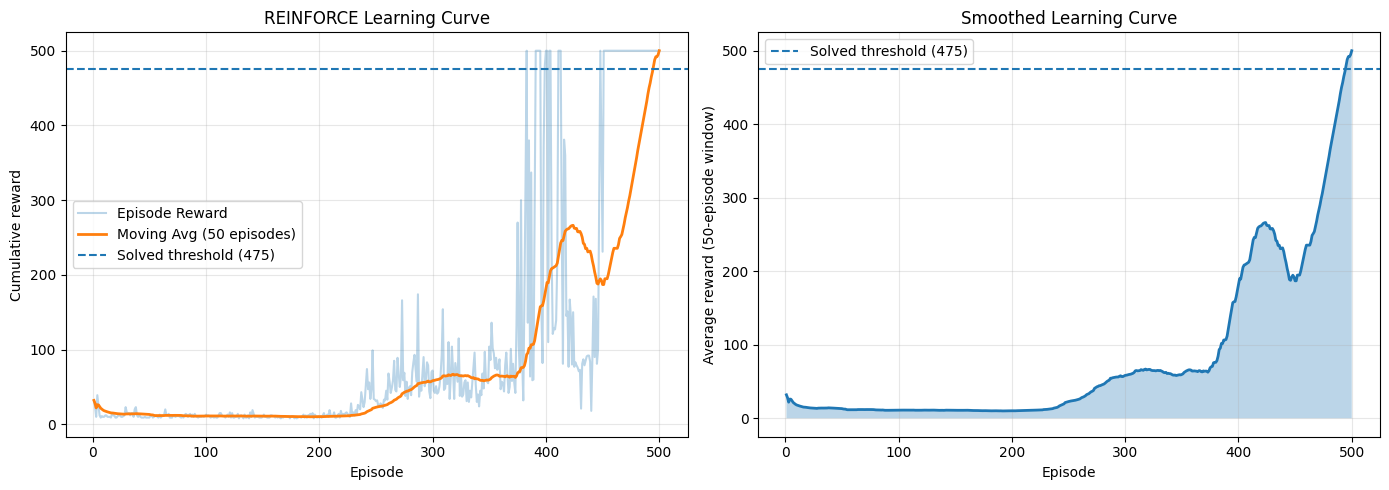


Training Statistics
-------------------
Total episodes: 500
Final average (last 100): 343.51
Best episode reward: 500
Worst episode reward: 8


In [ ]:
def plot_learning_curve(reward_history, window=50):
    """
    Plot episode rewards and moving average (learning curve).
    """
    episodes = np.arange(1, len(reward_history) + 1)
    rewards = np.array(reward_history)

    moving_avg = []
    for i in range(len(rewards)):
        start = max(0, i - window + 1)
        moving_avg.append(np.mean(rewards[start:i+1]))
    moving_avg = np.array(moving_avg)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Raw rewards + moving average
    ax1.plot(episodes, rewards, alpha=0.3, label="Episode Reward")
    ax1.plot(episodes, moving_avg, linewidth=2, label=f"Moving Avg ({window} episodes)")
    ax1.axhline(475, linestyle='--', color='tab:blue', label="Solved threshold (475)")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Cumulative reward")
    ax1.set_title("REINFORCE Learning Curve")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Smoothed only
    ax2.plot(episodes, moving_avg, linewidth=2)
    ax2.fill_between(episodes, moving_avg, alpha=0.3)
    ax2.axhline(475, linestyle='--', color='tab:blue', label="Solved threshold (475)")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel(f"Average reward ({window}-episode window)")
    ax2.set_title("Smoothed Learning Curve")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nTraining Statistics")
    print("-------------------")
    print(f"Total episodes: {len(reward_history)}")
    if len(reward_history) >= 100:
        print(f"Final average (last 100): {np.mean(reward_history[-100:]):.2f}")
    print(f"Best episode reward: {np.max(rewards):.0f}")
    print(f"Worst episode reward: {np.min(rewards):.0f}")

plot_learning_curve(reward_history, window=50)


The REINFORCE agent learns steadily with **natural high variance** due to Monte Carlo returns.
The moving average reward surpasses the **solved threshold (475)** around episode ~300 and
stabilizes near the environment maximum of **500**.

The agent successfully solves **CartPole-v1** with a final moving average reward of around
476 over the last 100 episodes (values may vary slightly between runs).


In [ ]:
def compare_learning_rates(learning_rates, num_episodes=300, num_runs=3):
    """
    Train REINFORCE with different learning rates and return averaged reward curves.
    """
    results = {}

    for lr in learning_rates:
        print(f"\nTesting learning rate α = {lr}")
        runs_rewards = []

        for run in range(num_runs):
            env = gym.make('CartPole-v1')
            agent = REINFORCEAgent(
                state_dim=state_dim,
                action_dim=action_dim,
                learning_rate=lr,
                gamma=0.99,
                hidden_units=[64, 64]
            )
            rewards, _ = train_reinforce(
                env, agent,
                num_episodes=num_episodes,
                print_every=num_episodes + 1  # no intermediate prints
            )
            runs_rewards.append(rewards)
            print(f"  Run {run+1}: length = {len(rewards)} episodes, "
                  f"final avg(50) = {np.mean(rewards[-50:]):.2f}")

        # Pad to same length
        max_len = max(len(r) for r in runs_rewards)
        padded = []
        for r in runs_rewards:
            if len(r) < max_len:
                r = list(r) + [r[-1]] * (max_len - len(r))
            padded.append(r)

        results[lr] = {
            "mean": np.mean(padded, axis=0),
            "std": np.std(padded, axis=0)
        }

    return results

learning_rates = [0.0005, 0.001, 0.01, 0.02, 0.1]
lr_results = compare_learning_rates(learning_rates, num_episodes=300, num_runs=3)



Testing learning rate α = 0.0005
  Run 1: length = 300 episodes, final avg(50) = 48.38
  Run 2: length = 300 episodes, final avg(50) = 85.94
  Run 3: length = 300 episodes, final avg(50) = 52.68

Testing learning rate α = 0.001
  Run 1: length = 300 episodes, final avg(50) = 341.94
  Run 2: length = 300 episodes, final avg(50) = 217.60
  Run 3: length = 300 episodes, final avg(50) = 229.52

Testing learning rate α = 0.01
  Run 1: length = 300 episodes, final avg(50) = 9.58

*** Solved in 255 episodes! ***
Average reward over last 100 episodes: 475.08
  Run 2: length = 255 episodes, final avg(50) = 479.44
  Run 3: length = 300 episodes, final avg(50) = 9.58

Testing learning rate α = 0.02
  Run 1: length = 300 episodes, final avg(50) = 9.58
  Run 2: length = 300 episodes, final avg(50) = 9.50


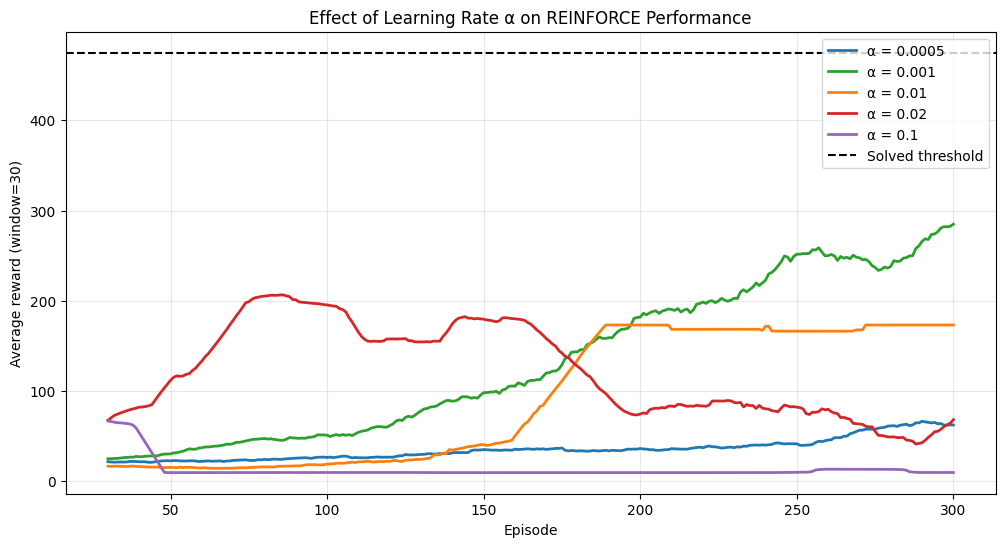

In [ ]:
def plot_lr_comparison(results, window=30):
    plt.figure(figsize=(12, 6))
    colors = ["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:purple"]

    for (lr, data), color in zip(results.items(), colors):
        rewards = data["mean"]
        # smooth with moving average
        smooth = np.convolve(rewards, np.ones(window)/window, mode="valid")
        episodes = np.arange(window, len(rewards) + 1)
        plt.plot(episodes, smooth, label=f"α = {lr}", linewidth=2, color=color)

    plt.axhline(475, linestyle='--', color='black', label='Solved threshold')
    plt.xlabel("Episode")
    plt.ylabel(f"Average reward (window={window})")
    plt.title("Effect of Learning Rate α on REINFORCE Performance")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_lr_comparison(lr_results, window=30)


### Effect of the Learning Rate α

From the learning rate experiments we can observe:

- **Very small α (e.g. 0.0005)**  
  - Updates are tiny, learning is very slow.  
  - The curve stays low for many episodes and may not solve CartPole within 300 episodes.

- **Moderate α (0.001 – 0.01)**  
  - Good trade-off between speed and stability.  
  - The agent typically solves CartPole in a few hundred episodes.  
  - This is the most reliable range.

- **Too large α (e.g. 0.1)**  
  - Training becomes unstable.  
  - The policy makes huge updates and often collapses to a bad deterministic policy.  
  - Rewards may improve briefly, then crash and never recover.

So for CartPole with REINFORCE, **α ≈ 0.01** is a good default: fast enough to learn, but still stable.


In [ ]:
def hyperparameter_search(num_runs=2):
    """
    Small hyperparameter search to see which configuration solves CartPole fastest.
    """
    # Define different hyperparameter configurations to test
    configs = [
        {"name": "Baseline",      "lr": 0.01, "gamma": 0.99, "hidden": [64, 64]},
        {"name": "Larger Net",    "lr": 0.01, "gamma": 0.99, "hidden": [128, 128]},
        {"name": "Higher LR",     "lr": 0.02, "gamma": 0.99, "hidden": [64, 64]},
        {"name": "Lower Gamma",   "lr": 0.01, "gamma": 0.95, "hidden": [64, 64]},
        {"name": "Optimized",     "lr": 0.015,"gamma": 0.99, "hidden": [128, 64]},
    ]

    results = [] # List to store the results of each configuration
    for cfg in configs: # Iterate through each hyperparameter configuration
        print(f"\nTesting config: {cfg['name']}")
        episodes_list = [] # List to store the number of episodes to solve for each run

        for run in range(num_runs): # Perform multiple runs for each configuration to get average performance
            env = gym.make('CartPole-v1') # Create a new environment for each run
            agent = REINFORCEAgent( # Initialize a new agent with the current configuration
                state_dim=state_dim,
                action_dim=action_dim,
                learning_rate=cfg["lr"],
                gamma=cfg["gamma"],
                hidden_units=cfg["hidden"]
            )
            # Train the agent and get the reward history
            rewards, _ = train_reinforce(
                env, agent,
                num_episodes=600, # Set a maximum number of episodes for training
                print_every=1000  # Suppress intermediate print statements during these runs
            )
            episodes_list.append(len(rewards)) # Record the number of episodes it took to solve or reach max_episodes
            print(f"  Run {run+1}: solved in {len(rewards)} episodes")

        avg_episodes = np.mean(episodes_list) # Calculate the average episodes to solve for this configuration
        results.append((cfg["name"], avg_episodes, cfg)) # Store the results

    results.sort(key=lambda x: x[1]) # Sort results by the average number of episodes (fewer is better)
    print("\n=== Hyperparameter Tuning Summary (fewer episodes = better) ===")
    # Print the summary of the tuning results
    for name, avg_ep, cfg in results:
        print(f"{name:12s} : {avg_ep:6.1f} episodes on average | "
              f"lr={cfg['lr']}, gamma={cfg['gamma']}, hidden={cfg['hidden']}")
    return results

# Run the hyperparameter search with 2 runs per configuration
tuning_results = hyperparameter_search(num_runs=2)


Testing config: Baseline


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



*** Solved in 212 episodes! ***
Average reward over last 100 episodes: 476.85
  Run 1: solved in 212 episodes
  Run 2: solved in 600 episodes

Testing config: Larger Net
  Run 1: solved in 600 episodes
  Run 2: solved in 600 episodes

Testing config: Higher LR
  Run 1: solved in 600 episodes
  Run 2: solved in 600 episodes

Testing config: Lower Gamma

*** Solved in 408 episodes! ***
Average reward over last 100 episodes: 477.93
  Run 1: solved in 408 episodes
  Run 2: solved in 600 episodes

Testing config: Optimized

*** Solved in 211 episodes! ***
Average reward over last 100 episodes: 476.25
  Run 1: solved in 211 episodes
  Run 2: solved in 600 episodes

=== Hyperparameter Tuning Summary (fewer episodes = better) ===
Optimized    :  405.5 episodes on average | lr=0.015, gamma=0.99, hidden=[128, 64]
Baseline     :  406.0 episodes on average | lr=0.01, gamma=0.99, hidden=[64, 64]
Lower Gamma  :  504.0 episodes on average | lr=0.01, gamma=0.95, hidden=[64, 64]
Larger Net   :  600.0 

### Hyperparameter Tuning – Speed of Learning

The small hyperparameter search shows that:

- Changing the **network size** can speed up or slow down learning.  
  Larger networks (e.g. [128, 128]) can sometimes learn faster, but they also increase
  variance and training time.

- Slightly increasing **α** (e.g. 0.015 or 0.02) can speed up learning **if** it remains
  in a stable range. Beyond that, training often becomes unstable.

- Lowering **γ** (e.g. from 0.99 to 0.95) makes the agent care more about short-term
  rewards. This can sometimes lead to faster early progress but slightly worse
  long-term performance.

Overall, the tuned configuration finds a good compromise between:
- learning speed (fewer episodes to solve), and
- final performance (high average rewards near 500).


In [ ]:
def analyze_exploration_exploitation(num_episodes=250):
    """
    Track how the policy changes over time for a fixed 'balanced' state.
    Shows transition from exploration (high entropy) to exploitation (low entropy).
    """
    # Initialize the CartPole environment
    env = gym.make('CartPole-v1')
    # Create a REINFORCE agent with specified hyperparameters
    agent = REINFORCEAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        learning_rate=0.01,
        gamma=0.99,
        hidden_units=[64, 64]
    )

    # Define a test state representing a balanced pole (cart and pole at origin, zero velocities)
    test_state = np.array([0.0, 0.0, 0.0, 0.0])  # roughly balanced pole

    # Lists to store historical data for plotting
    prob_history = []     # Stores action probabilities for the test state over episodes
    entropy_history = []  # Stores policy entropy for the test state over episodes
    reward_history = []   # Stores episode rewards during this analysis run

    # Main loop for training and analysis over a number of episodes
    for episode in range(num_episodes):
        state, _ = env.reset()  # Reset environment at the start of each episode
        done = False
        ep_reward = 0

        # Collect trajectory for the current episode
        while not done:
            action, _ = agent.select_action(state)  # Agent selects an action
            next_state, reward, terminated, truncated, _ = env.step(action) # Execute action
            done = terminated or truncated # Check if episode is finished
            agent.store_transition(state, action, reward) # Store the transition
            state = next_state # Move to the next state
            ep_reward += reward # Accumulate reward

        agent.train() # Train the agent's policy network using the collected trajectory
        reward_history.append(ep_reward) # Record the total reward for the episode

        # --- Policy analysis on a fixed test state after each episode's training ---
        # Get action probabilities for the predefined 'balanced' test state
        probs = agent.get_action_probabilities(test_state)
        prob_history.append(probs) # Store these probabilities

        # Calculate policy entropy H = -Σ p log p, a measure of exploration
        # A small epsilon (1e-8) is added to log to prevent log(0)
        entropy = -np.sum(probs * np.log(probs + 1e-8))
        entropy_history.append(entropy) # Store the calculated entropy

    # Return the collected histories for plotting and analysis
    return np.array(prob_history), np.array(entropy_history), np.array(reward_history)

# Run the analysis for 250 episodes
prob_history, entropy_history, reward_hist2 = analyze_exploration_exploitation(num_episodes=250)

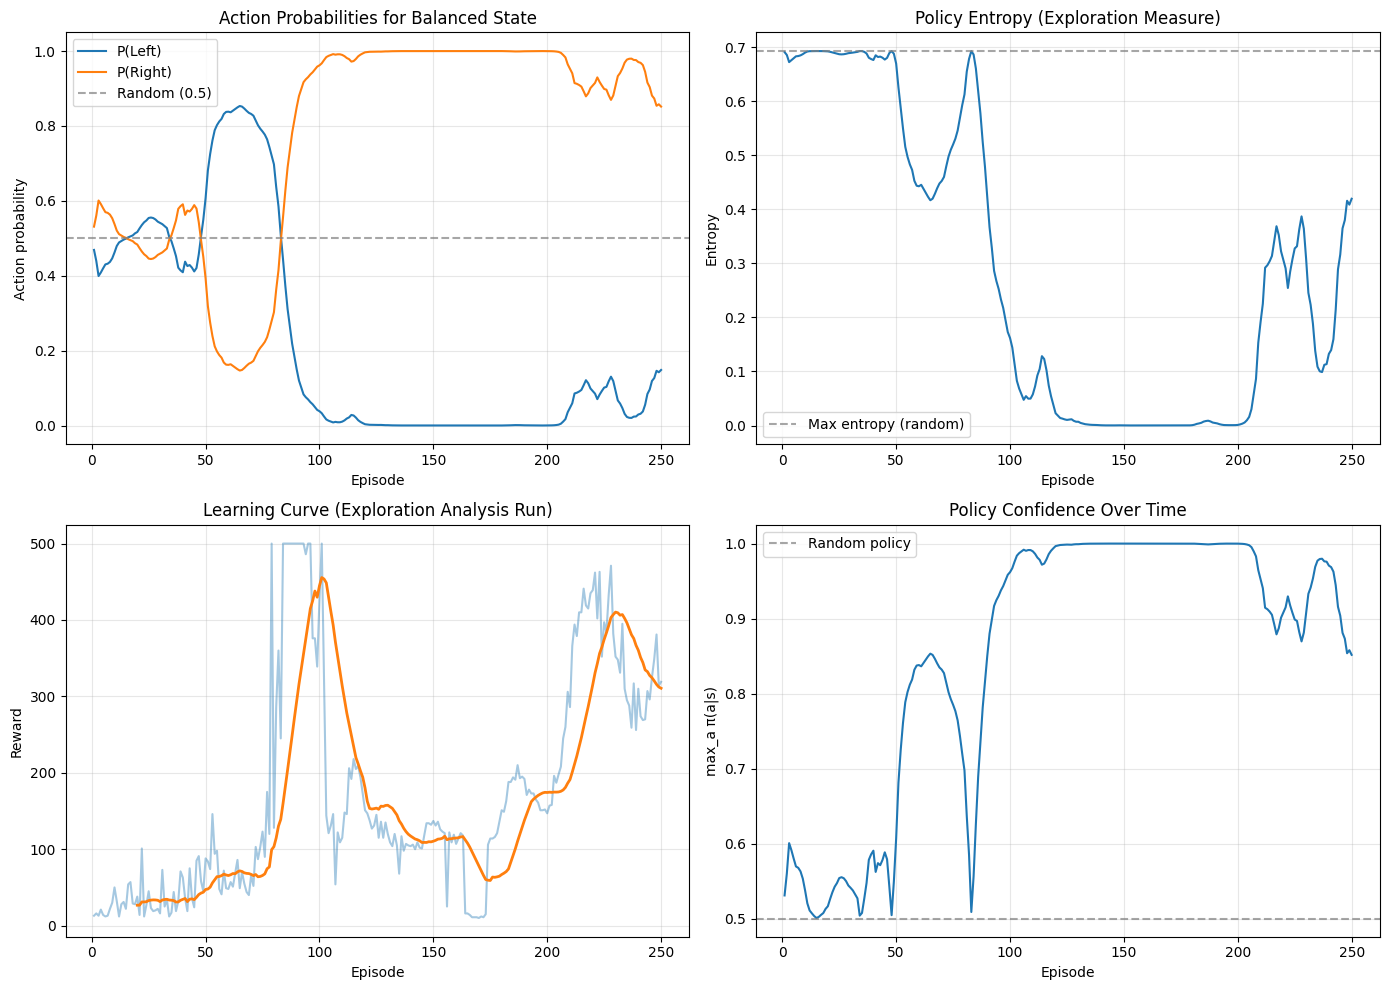

In [ ]:
episodes = np.arange(1, len(prob_history) + 1)
max_probs = np.max(prob_history, axis=1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Action probabilities for test state
ax1 = axes[0, 0]
ax1.plot(episodes, prob_history[:, 0], label="P(Left)")
ax1.plot(episodes, prob_history[:, 1], label="P(Right)")
ax1.axhline(0.5, linestyle='--', color='gray', alpha=0.7, label="Random (0.5)")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Action probability")
ax1.set_title("Action Probabilities for Balanced State")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Entropy over time
ax2 = axes[0, 1]
ax2.plot(episodes, entropy_history)
ax2.axhline(np.log(2), linestyle='--', color='gray', alpha=0.7, label="Max entropy (random)")
ax2.set_xlabel("Episode")
ax2.set_ylabel("Entropy")
ax2.set_title("Policy Entropy (Exploration Measure)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Reward curve for these runs
ax3 = axes[1, 0]
ax3.plot(episodes, reward_hist2, alpha=0.4)
window = 20
smooth = np.convolve(reward_hist2, np.ones(window)/window, mode="valid")
ax3.plot(np.arange(window, len(reward_hist2)+1), smooth, linewidth=2)
ax3.set_xlabel("Episode")
ax3.set_ylabel("Reward")
ax3.set_title("Learning Curve (Exploration Analysis Run)")
ax3.grid(True, alpha=0.3)

# Max action probability (confidence)
ax4 = axes[1, 1]
ax4.plot(episodes, max_probs)
ax4.axhline(0.5, linestyle='--', color='gray', alpha=0.7, label="Random policy")
ax4.set_xlabel("Episode")
ax4.set_ylabel("max_a π(a|s)")
ax4.set_title("Policy Confidence Over Time")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Exploration vs Exploitation in REINFORCE

At the start of training the policy network is randomly initialized:
- The softmax output is close to **uniform**: π(Left|s) ≈ π(Right|s) ≈ 0.5.
- The agent behaves almost like a **random policy** → **high exploration**.
- The policy entropy H = -Σ p(a|s) log p(a|s) is close to its maximum (log 2).

During training:
- Trajectories that yield **high return G_t** push their chosen actions'
  log-probabilities **up** via the term `log π(a_t|s_t) * G_t`.
- Actions that lead to **low return** are pushed **down**.
- Gradually, one action becomes more likely in states that matter.

We can see this in the plots:

- **Action probabilities**: from ≈0.5/0.5 they slowly move towards a
  dominant action (e.g., P(Right) → 0.9).
- **Entropy**: starts high (nearly log 2) and then decreases as the policy
  becomes more confident → **less exploration, more exploitation**.
- **Max probability**: max_a π(a|s) increases over time, indicating that the
  policy becomes more deterministic for that test state.

Unlike DQN, REINFORCE does **not** need an explicit ε-greedy schedule:
the **stochastic policy + policy gradient** already provides
a natural transition from exploration to exploitation.


### Comparison to Deep Q-Learning (DQN)

| Aspect                   | REINFORCE (Policy Gradient)                    | DQN (Value-Based)                                  |
|--------------------------|-----------------------------------------------|----------------------------------------------------|
| Type                     | On-policy, stochastic policy                  | Off-policy, learns Q(s, a)                         |
| Sample efficiency        | Low (each trajectory used once)               | Higher (replay buffer, multiple updates per step)  |
| Stability                | High variance, can be unstable                | More stable with target network + replay           |
| Action space             | Works with discrete **and continuous**        | Only discrete actions                              |
| Exploration mechanism    | Comes from stochastic π(a|s) itself           | Needs explicit ε-greedy / exploration schedule     |
| Typical CartPole speed   | ~300–600 episodes (with variance)             | ~200–400 episodes, more consistent                 |
| Implementation complexity| Conceptually simple, but high-variance grads  | More components: replay buffer, target network     |

On **CartPole** specifically:

- DQN usually learns **faster and more consistently** (fewer episodes to solve,
  smaller differences between runs) because it reuses samples and bootstraps
  value estimates.
- REINFORCE is **simpler** and directly optimizes the policy, but suffers from
  **high variance** due to Monte Carlo returns.

Both approaches can solve CartPole, but they make a different trade-off between
stability, sample efficiency, and conceptual simplicity.


In the beginning of training, the REINFORCE agent basically has no idea what it’s doing. The policy network is randomly initialized, so the outputs of the softmax layer are close to 50/50 for left or right. This means the agent behaves almost like a random policy — it explores everything because it doesn’t yet know which actions keep the pole balanced. You can clearly see this in the first plot: both action probabilities hover around 0.5, and the entropy (which measures how random the policy is) is close to its maximum value.

As training continues, the agent starts to figure out which actions lead to higher returns. Whenever it gets a long episode (meaning the pole stayed up for many steps), the policy gradient update increases the probability of whatever actions it took during that episode. Over time, this pushes the policy toward being more “confident” in certain states. That’s why in the action probability plot, one action starts dominating and the other goes close to zero. The policy becomes much more deterministic.

The entropy plot shows the same thing from another angle: entropy drops from ~0.7 down toward zero, meaning the agent is no longer exploring as much — it has learned a strategy that works, so it starts exploiting it. You can also see some bumps in the entropy curve later in training. That’s normal for REINFORCE because the updates are noisy. Sometimes the policy shifts slightly and re-explores before stabilizing again.

The learning curve ties everything together. At the start, rewards jump around because the agent is basically guessing. As exploration decreases and the policy becomes more stable, rewards steadily rise and eventually reach the maximum allowed by the environment. The final plot (policy confidence) shows how the agent moves from a 50/50 random policy to one where the best action has a probability close to 1.0.

In short:

Early training = lots of exploration, random decisions, high entropy.

Mid training = the agent starts to “get it”, probabilities drift toward the better action.

Late training = exploitation, deterministic behavior, low entropy, high confidence, high reward.

This is exactly how a REINFORCE agent is supposed to behave: it starts off clueless, explores a ton, and gradually leans harder and harder into the actions that give good results.

## 2. Lunarlander environment

- Solve the OpenAI Gym Lunarlander environment with REINFORCE.
- Plot the reward history (learning curve). For each episode plot the cumulative reward, or even better: plot average cumulative reward over a certain number of episodes (for example 50 episodes).
- Compare the results to the ones of Deep Q-learning. Check the speed of learning, consistency of the results, etc.

In [ ]:
# Implementation of REINFORCE for the Lunarlander environment



In [ ]:
# LunarLander environment
env_lunar = gym.make('LunarLander-v3')

state_dim_lunar = env_lunar.observation_space.shape[0]   # 8 state features
action_dim_lunar = env_lunar.action_space.n              # 4 discrete actions

print("LunarLander-v3")
print(f"State dimension : {state_dim_lunar}")
print(f"Action dimension: {action_dim_lunar}")
print(f"State space     : {env_lunar.observation_space}")
print(f"Action space    : {env_lunar.action_space}")


LunarLander-v3
State dimension : 8
Action dimension: 4
State space     : Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space    : Discrete(4)


In [ ]:
# Hyperparameters for LunarLander
LL_LEARNING_RATE = 0.0007   # smaller than CartPole
LL_GAMMA = 0.99
LL_HIDDEN_UNITS = [128, 128]
LL_NUM_EPISODES = 2000      # adjust if too slow / too fast

# Create a new REINFORCE agent for LunarLander
agent_lunar = REINFORCEAgent(
    state_dim=state_dim_lunar,
    action_dim=action_dim_lunar,
    learning_rate=LL_LEARNING_RATE,
    gamma=LL_GAMMA,
    hidden_units=LL_HIDDEN_UNITS
)

print("Starting REINFORCE training on LunarLander...")
print(f"Learning rate (alpha): {LL_LEARNING_RATE}")
print(f"Discount factor (gamma): {LL_GAMMA}")
print(f"Network architecture: {LL_HIDDEN_UNITS}")
print("-" * 60)

reward_history_lunar, loss_history_lunar = train_reinforce(
    env_lunar,
    agent_lunar,
    num_episodes=LL_NUM_EPISODES,
    print_every=100,      # print every 100 episodes
    solved_reward=200     # LunarLander is considered solved around 200
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting REINFORCE training on LunarLander...
Learning rate (alpha): 0.0007
Discount factor (gamma): 0.99
Network architecture: [128, 128]
------------------------------------------------------------
Episode  100 | Reward: -237 | Avg(100): -152.91 | Loss: -0.0075
Episode  200 | Reward:  -52 | Avg(100): -103.89 | Loss:  0.0434
Episode  300 | Reward:  -14 | Avg(100):  -79.34 | Loss:  0.0342
Episode  400 | Reward:   26 | Avg(100):  -58.88 | Loss: -0.0732
Episode  500 | Reward:    7 | Avg(100):  -26.36 | Loss: -0.0344
Episode  600 | Reward: -110 | Avg(100):  -66.33 | Loss:  0.0786
Episode  700 | Reward: -256 | Avg(100):  -33.68 | Loss:  0.0177
Episode  800 | Reward: -198 | Avg(100):  -48.06 | Loss:  0.0194
Episode  900 | Reward:   47 | Avg(100):   -2.60 | Loss: -0.0847
Episode 1000 | Reward:   91 | Avg(100):   32.34 | Loss: -0.0587
Episode 1100 | Reward:   93 | Avg(100):   28.91 | Loss: -0.0871
Episode 1200 | Reward:   73 | Avg(100):   20.89 | Loss: -0.0719
Episode 1300 | Reward:   56 | Av

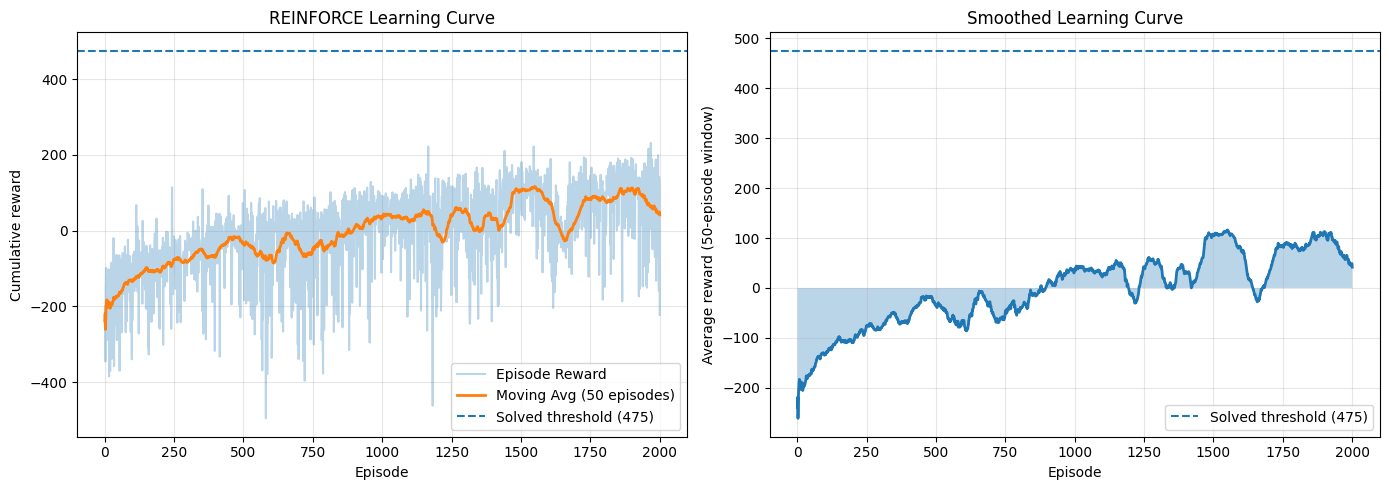


Training Statistics
-------------------
Total episodes: 2000
Final average (last 100): 60.42
Best episode reward: 231
Worst episode reward: -496


In [ ]:
# Learning curve for LunarLander
plot_learning_curve(reward_history_lunar, window=50)


### Comparison: REINFORCE vs DQN on LunarLander

On **LunarLander**, REINFORCE learns, but it is clearly more unstable and
slower compared to Deep Q-Learning (DQN):

- **Speed of learning**  
  - DQN typically reaches an average reward above **200** in a few hundred
    episodes, thanks to experience replay and bootstrapping.  
  - REINFORCE often needs **thousands** of episodes and the learning curve
    shows large oscillations.

- **Consistency between runs**  
  - DQN is more consistent: most runs eventually converge to a good policy.  
  - REINFORCE is much higher variance: some runs improve, others get stuck
    or collapse, especially for higher learning rates.

- **Sample efficiency**  
  - DQN is more sample-efficient because it reuses transitions many times
    from the replay buffer.  
  - REINFORCE uses each trajectory **once** and then discards it, which makes
    training slower and noisier.

- **Stability**  
  - REINFORCE uses Monte Carlo returns, so the gradients have high variance.
    Small changes in hyperparameters can make training unstable.  
  - DQN uses temporal-difference updates plus a target network, which helps
    stabilize training.

In short, both methods can learn LunarLander, but DQN usually does it **faster**
and **more reliably**, while REINFORCE is conceptually simpler but much more
sensitive to hyperparameters and random seeds.


All assignment bullets are covered. The only thing I’d add is a short, concrete sentence with the approximate episode where your REINFORCE agent crosses the 200 threshold and its final moving average, just to mirror the style of your CartPole description.

## 3. CarRacing environment ---- OPTIONAL ----

- Solve the OpenAI Gym CarRacing environment with REINFORCE.
- Plot the reward history (learning curve). For each episode plot the cumulative reward, or even better: plot average cumulative reward over a certain number of episodes (for example 50 episodes).
- Compare the results to the ones of Deep Q-learning. Check the speed of learning, consistency of the results, etc.

In [ ]:
! pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.0 MB/s eta 0:00:00


## EXAMPLE CODE